In [1]:
import os
import pandas as pd
import numpy as np
import json

In [ ]:
meta_df = pd.read_csv('MEISD/MEISD_text.csv')

In [ ]:
meta_df.shape

In [ ]:
meta_df.head(3)

In [ ]:
# For the multilabel classification we use:
columns = ['Utterances', 'sentiment', 'emotion', 'intensity', 'emotion2', 'intensity2', 'emotion3', 'intensity3']
meta_dfs = meta_df[columns].copy()

In [ ]:
# Define emotion and sentiment mappings
emotion_map = {
    'neutral': 0,
    'acceptance': 1,
    'disgust': 2,
    'surprise': 3,
    'joy': 4,
    'sadness': 5,
    'anger': 6,
    'like': 7,
    'fear': 8
}

sentiment_map = {
    'positive': 1,
    'negative': 0,
    'neutral': 2
}

In [ ]:
meta_dfs.loc[:, 'sentiment'] = pd.to_numeric(meta_dfs['sentiment'].map(sentiment_map).fillna(2).astype(int))  # Use 2 as a default for unknown
meta_dfs.loc[:, 'emotion'] = pd.to_numeric(meta_dfs['emotion'].map(emotion_map))
meta_dfs.loc[:, 'emotion2'] = pd.to_numeric(meta_dfs['emotion2'].map(emotion_map))
meta_dfs.loc[:, 'emotion3'] = pd.to_numeric(meta_dfs['emotion3'].map(emotion_map))

# Convert intensity columns to numeric
meta_dfs.loc[:, 'intensity'] = pd.to_numeric(meta_dfs['intensity'], errors='coerce')
meta_dfs.loc[:, 'intensity2'] = pd.to_numeric(meta_dfs['intensity2'], errors='coerce')
meta_dfs.loc[:, 'intensity3'] = pd.to_numeric(meta_dfs['intensity3'], errors='coerce')

In [ ]:
# Create new columns
# 1. Combined emotions column (as a list of int)
meta_dfs['combined_emotions'] = meta_dfs[['emotion', 'emotion2', 'emotion3']].apply(lambda x: x.dropna().unique().astype(int).tolist(), axis=1)

# 2. Combined intensity column (as a list of int)
meta_dfs['combined_intensities'] = meta_dfs[['intensity', 'intensity2', 'intensity3']].apply(lambda x: x.dropna().unique().astype(int).tolist(), axis=1)

In [ ]:
columns = ['Utterances', 'sentiment', 'combined_emotions', 'combined_intensities']
multi_column_MEISD = meta_dfs[columns]

In [ ]:
multi_column_MEISD.head()

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Create separate binary vectors for sentiment, emotions, and intensity

mlb_emotion = MultiLabelBinarizer()
emotion_binarized = mlb_emotion.fit_transform(meta_dfs['combined_emotions'])
emotion_df = pd.DataFrame(emotion_binarized)
emotion_df.columns = [f'emotion_{i + 1}' for i in range(emotion_df.shape[1])]

mlb_intensity = MultiLabelBinarizer()
intensity_binarized = mlb_intensity.fit_transform(meta_dfs['combined_intensities'])
intensity_df = pd.DataFrame(intensity_binarized)
intensity_df.columns = [f'intensity_{i + 1}' for i in range(intensity_df.shape[1])]

sentiment_values = meta_dfs['sentiment'].values.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
sentiment_encoded = encoder.fit_transform(sentiment_values)

# Convert the result to a DataFrame
sentiment_df = pd.DataFrame(sentiment_encoded, columns=encoder.get_feature_names_out(['sentiment']))
sentiment_df = sentiment_df.astype(int)
multi_label_binarizer_MEISD = pd.concat([meta_dfs['Utterances'], sentiment_df, emotion_df, intensity_df], axis=1)

In [ ]:
multi_label_binarizer_MEISD.head()

In [ ]:
# Save multi_column_MEISD and multi_label_binarizer_MEISD to a CSV file
multi_column_MEISD.to_csv('multi_column_MEISD.csv', index=False)
multi_label_binarizer_MEISD.to_csv('multi_label_binarizer_MEISD.csv', index=False)

In [ ]:
# For our task we remove the categories with small number of articles
columns = multi_label_binarizer_MEISD.columns
# Find the frequencies of the articles in every category
categor_freq = multi_label_binarizer_MEISD[columns[2:]].sum()/multi_label_binarizer_MEISD.shape[0]
categor_freq

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,3)
plt.bar(categor_freq.index, categor_freq.values)
_ = plt.xticks(rotation = 45)

Data exploration step: plot abstracts using PCA

In [2]:
multi_label_binarizer_MEISD = pd.read_csv('multi_label_binarizer_MEISD.csv')

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Julix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
multi_label_binarizer_MEISD.shape

(20017, 16)

In [5]:
df0 = multi_label_binarizer_MEISD

In [ ]:
# To reduce the data size we randomly subsample abstracts with a single category
sample_pca = df0.loc[df0.iloc[:,1:].apply(sum, axis=1) == 1,:].sample(n = 504, random_state = 4)

In [ ]:
sample_pca.head()

In [ ]:
X = TfidfVectorizer(stop_words='english').fit_transform(sample_pca.Utterances).todense()

In [7]:
X = TfidfVectorizer(stop_words='english').fit_transform(df0.Utterances).todense()

In [8]:
import numpy as np
from sklearn.decomposition import PCA

X_array = np.asarray(X) 

pca = PCA(n_components=2)
data2D = pd.DataFrame(pca.fit_transform(X_array), columns=['PC1', 'PC2'])

In [9]:
data2D

,PC1,PC2
0,-0.008059,-0.022402
1,-0.013171,-0.029411
2,-0.014860,-0.023826
3,-0.014355,-0.023160
4,-0.016173,-0.029118
...,...,...
20012,-0.034456,0.005719
20013,-0.015482,-0.035266
20014,-0.014801,-0.024147
20015,-0.015517,-0.023273


In [12]:
# Get the corresponding categories for abstracts
color = df0.iloc[:,2:].apply(lambda x: x.index[x>0][0], axis = 1)
data2D['category'] = color.to_list()

In [13]:
data2D

,PC1,PC2,category
0,-0.008059,-0.022402,sentiment_2
1,-0.013171,-0.029411,sentiment_2
2,-0.014860,-0.023826,sentiment_2
3,-0.014355,-0.023160,sentiment_2
4,-0.016173,-0.029118,sentiment_2
...,...,...,...
20012,-0.034456,0.005719,emotion_3
20013,-0.015482,-0.035266,emotion_3
20014,-0.014801,-0.024147,emotion_2
20015,-0.015517,-0.023273,emotion_3


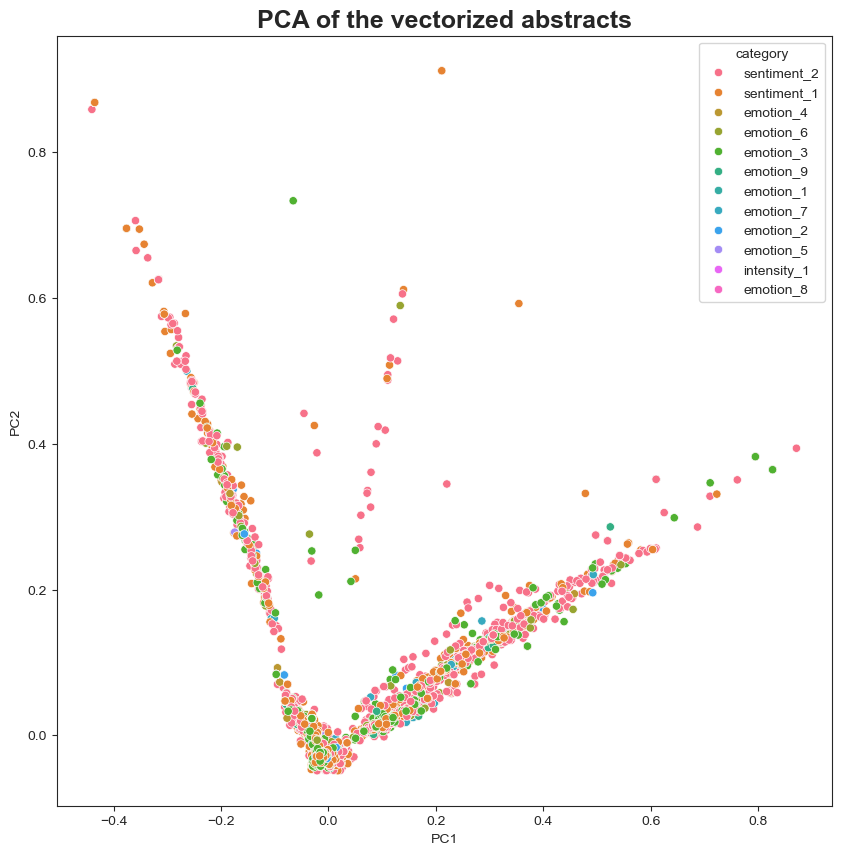

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
sns.set_style("ticks")
_=sns.scatterplot(data=data2D, x='PC1', y='PC2', hue='category') \
    .set_title("PCA of the vectorized abstracts", fontdict= { 'fontsize': 18, 'fontweight':'bold'})
